In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
labels_df = pd.read_csv('data/secom_labels.data', sep=' ', header = None)
labels_df.columns = ['Label', 'Date']
labels_df['Date'] = pd.to_datetime(labels_df['Date'], format = "%d/%m/%Y %H:%M:%S")
print('labels_df shape = {}'.format(labels_df.shape))
labels_df.head()

labels_df shape = (1567, 2)


,Label,Date
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


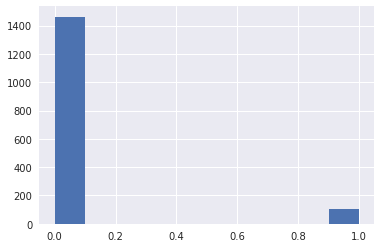

In [3]:
labels_df['Label'] = labels_df['Label'].apply(lambda x: 0 if x == -1 else 1)
labels_df['Label'].hist()

In [4]:
label_sum = labels_df['Label'].groupby(labels_df['Date'].dt.date).sum().reset_index()
label_count = labels_df['Label'].groupby(labels_df['Date'].dt.date).count().reset_index()
label_day = pd.merge(label_sum, label_count, on='Date')
label_day.columns = ['Date', 'Sum', 'Count']
label_day['Date'] = pd.to_datetime(label_day['Date'])
label_day.head()

,Date,Sum,Count
0,2008-07-19,3,12
1,2008-07-20,0,1
2,2008-07-21,1,2
3,2008-07-22,0,6
4,2008-07-23,0,2


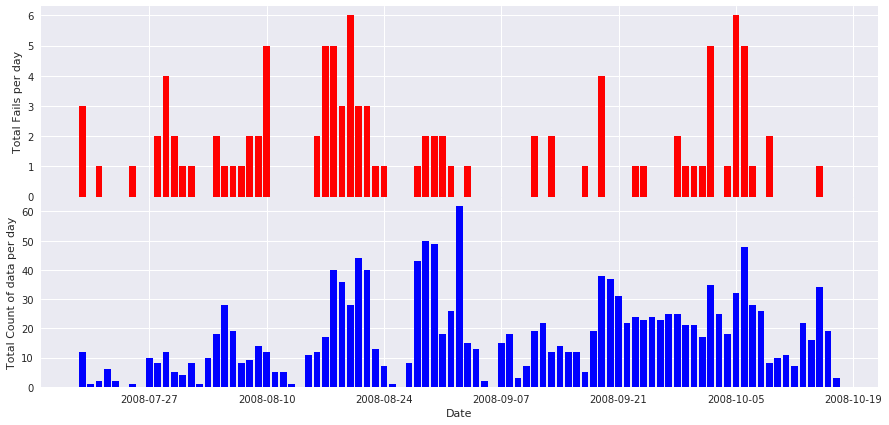

In [5]:
# Create a figure with shared X axis
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (15,7))

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Set the width of the bars to be 1 day
#width = np.timedelta64(1, 'D')

# Plot the Sum of fails per day and count of entries per day
axs[0].bar(label_day['Date'], label_day['Sum'], color = 'red')
axs[1].bar(label_day['Date'], label_day['Count'], color = 'blue')
axs[0].set_ylabel('Total Fails per day')
axs[1].set_ylabel('Total Count of data per day')
axs[1].set_xlabel('Date');

In [ ]:
# Data export for GCP AutoML

In [9]:
data_df = pd.read_csv('data/secom.data', sep=' ', header = None)
print('data_df shape = {}'.format(data_df.shape))
data_df.columns = ['x_{}'.format(i) for i in range (0,590)]
data_df.head()

data_df shape = (1567, 590)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [15]:
merged_df = data_df.merge(labels_df, left_index=True, right_index=True)
print(merged_df.shape)
merged_df.head()

(1567, 592)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,Label,Date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [12]:
split_date = '2008-10-01'
train_df = merged_df[merged_df['Date'] < split_date]
test_df = merged_df[merged_df['Date'] >= split_date]
train_df.shape

(1208, 592)

In [16]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

In [ ]:
# Continue manual analysis

In [17]:
data_df_missing_count = data_df.isna().sum()
data_df_missing_count[data_df_missing_count > 100].sort_values(ascending = False)

x_293    1429
x_157    1429
x_158    1429
x_292    1429
x_85     1341
x_492    1341
x_220    1341
x_358    1341
x_517    1018
x_516    1018
x_384    1018
x_383    1018
x_382    1018
x_245    1018
x_246    1018
x_518    1018
x_244    1018
x_111    1018
x_110    1018
x_109    1018
x_580     949
x_581     949
x_579     949
x_578     949
x_72      794
x_346     794
x_73      794
x_345     794
x_247     715
x_112     715
x_385     715
x_519     715
x_568     273
x_563     273
x_567     273
x_566     273
x_569     273
x_565     273
x_564     273
x_562     273
x_547     260
x_546     260
x_556     260
x_555     260
x_554     260
x_553     260
x_552     260
x_551     260
x_550     260
x_549     260
x_548     260
x_557     260
dtype: int64

In [18]:
def train_test_split(data_df, labels_df, split_date):
    y_train = labels_df['Label'][labels_df['Date'] < split_date]
    y_test = labels_df['Label'][labels_df['Date'] >= split_date]
    
    X_train = data_df.loc[y_train.index]
    X_test = data_df.loc[y_test.index]
    
    print('X_train, y_train, X_test, y_test shapes: {}, {}, {}, {}'\
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = train_test_split(data_df, labels_df, '2008-10-01')

X_train, y_train, X_test, y_test shapes: (1208, 590), (1208,), (359, 590), (359,)


In [20]:
# Classification

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [22]:
def classifier_comparison(X_train, y_train, X_test, y_test):
    names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Gradient Boosting", "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        MLPClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
        print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
        y_pred = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))

In [23]:
# Imputation

In [24]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [25]:
classifier_comparison(X_train_imp, y_train, X_test_imp, y_test)

Nearest Neighbors train AUC: 0.517404583459689
Nearest Neighbors test AUC: 0.49554896142433236

Decision Tree train AUC: 1.0
Decision Tree test AUC: 0.5231993525762072

Random Forest train AUC: 0.9146341463414633
Random Forest test AUC: 0.49851632047477745

Neural Net train AUC: 0.5
Neural Net test AUC: 0.5

AdaBoost train AUC: 0.8719512195121951
AdaBoost test AUC: 0.5093741570002697

Gradient Boosting train AUC: 0.9207317073170731
Gradient Boosting test AUC: 0.4910979228486647

Naive Bayes train AUC: 0.6448576874756313
Naive Bayes test AUC: 0.5735095764769356

QDA train AUC: 0.5304878048780488
QDA test AUC: 0.49851632047477745



In [16]:
# SMOTE

In [27]:
!pip install imblearn

    100% |████████████████████████████████| 174kB 8.0MB/s ta 0:00:01
    100% |████████████████████████████████| 6.6MB 4.9MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 28.0MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [28]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_imp_smt, y_train_smt = smt.fit_sample(X_train_imp, y_train)

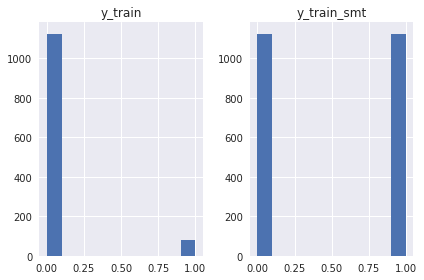

In [29]:
plt.subplot(1,2,1)
plt.hist(y_train)
plt.title('y_train')
plt.subplot(1,2,2)
plt.hist(y_train_smt)
plt.title('y_train_smt')
plt.tight_layout();

In [30]:
classifier_comparison(X_train_imp_smt, y_train_smt, X_test_imp, y_test)

Nearest Neighbors train AUC: 0.8556838365896979
Nearest Neighbors test AUC: 0.49588616131642843

Decision Tree train AUC: 1.0
Decision Tree test AUC: 0.4950094415969786

Random Forest train AUC: 0.9991119005328597
Random Forest test AUC: 0.49851632047477745

Neural Net train AUC: 0.8197158081705151
Neural Net test AUC: 0.4691799298624224

AdaBoost train AUC: 0.9791296625222026
AdaBoost test AUC: 0.5078904774750471

Gradient Boosting train AUC: 1.0
Gradient Boosting test AUC: 0.4970326409495549

Naive Bayes train AUC: 0.6452042628774424
Naive Bayes test AUC: 0.6238872403560831

QDA train AUC: 1.0
QDA test AUC: 0.5



In [ ]:
#PCA

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=0.97)
pca.fit(X_train_imp)  

print(pca.explained_variance_ratio_)  

[0.57427138 0.25201396 0.09608772 0.0263604  0.01679814 0.00590311]


In [33]:
X_train_imp_pca = pca.transform(X_train_imp)
X_test_imp_pca = pca.transform(X_test_imp)
classifier_comparison(X_train_imp_pca, y_train, X_test_imp_pca, y_test)

Nearest Neighbors train AUC: 0.5361413161200884
Nearest Neighbors test AUC: 0.49851632047477745

Decision Tree train AUC: 1.0
Decision Tree test AUC: 0.4737658483949285

Random Forest train AUC: 0.8841463414634146
Random Forest test AUC: 0.5

Neural Net train AUC: 0.5162782134038038
Neural Net test AUC: 0.5108578365254923

AdaBoost train AUC: 0.559199410821817
AdaBoost test AUC: 0.5

Gradient Boosting train AUC: 0.6768292682926829
Gradient Boosting test AUC: 0.5

Naive Bayes train AUC: 0.5363470952649136
Naive Bayes test AUC: 0.49851632047477745

QDA train AUC: 0.5363470952649136
QDA test AUC: 0.49851632047477745



In [34]:
pca_smt = PCA(n_components=0.97)
pca_smt.fit(X_train_imp_smt)  

print(pca_smt.explained_variance_ratio_)  

[0.57594384 0.22948156 0.08717974 0.05187176 0.01909646 0.00644905]


In [35]:
X_train_imp_smt_pca = pca_smt.transform(X_train_imp_smt)
X_test_imp_pca = pca_smt.transform(X_test_imp)
classifier_comparison(X_train_imp_smt_pca, y_train_smt, X_test_imp_pca, y_test)

Nearest Neighbors train AUC: 0.8872113676731794
Nearest Neighbors test AUC: 0.5403965470731049

Decision Tree train AUC: 1.0
Decision Tree test AUC: 0.5957647693552739

Random Forest train AUC: 0.9955595026642985
Random Forest test AUC: 0.5360129484758566

Neural Net train AUC: 0.6962699822380106
Neural Net test AUC: 0.4929862422444025

AdaBoost train AUC: 0.7286856127886323
AdaBoost test AUC: 0.5012139196115457

Gradient Boosting train AUC: 0.8512433392539964
Gradient Boosting test AUC: 0.4632452117615322

Naive Bayes train AUC: 0.5843694493783305
Naive Bayes test AUC: 0.34751820879417317

QDA train AUC: 0.5910301953818827
QDA test AUC: 0.326274615592123



In [38]:
from sklearn.model_selection import GridSearchCV

In [37]:
name = 'Random Forest'
clf = RandomForestClassifier()
clf.fit(X_train_imp_smt_pca, y_train_smt)
y_pred = clf.predict(X_train_imp_smt_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, y_pred)
print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
y_pred = clf.predict(X_test_imp_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))

Random Forest train AUC: 0.9986678507992895
Random Forest test AUC: 0.5330455894254115



In [50]:
param_grid = {
  "n_estimators": [10, 100],
  "max_depth": [3, 5],
  "max_features": [0.5, 0.8],
  "min_samples_split": [2, 3, 10],
  "bootstrap": [True, False],
  "criterion": ["gini", "entropy"]}
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5).fit(X_train_imp_smt_pca, y_train_smt)

In [51]:
y_pred = grid_search.predict(X_train_imp_smt_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, y_pred)
print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
y_pred = grid_search.predict(X_test_imp_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))

Random Forest train AUC: 0.7437833037300177
Random Forest test AUC: 0.3925006743997842



In [ ]:
# Looks like no good model